# Лабораторная работа №4. Кластеризация

**Цель работы**: изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

**Датасет**: https://www.kaggle.com/datasets/uciml/glass

**Описание**:

Это набор данных для идентификации стекла от UCI. Он содержит 10 атрибутов, включая идентификатор. Ответ: тип стекла (7 дискретных значений).

| **Название переменной** | **Описание** |
| --- | --- |
| RI | Показатель преломления |
| Na | Натрий (единица измерения: массовая доля в соответствующем оксиде, как и атрибуты далее) |
| Mg | Магний |
| Al | Алюминий |
| Si | Кремний |
| K | Калий |
| Ca | Кальций |
| Ba | Барий |
| Fe | Железо |
| Type | Тип стекла |

---

## Описание данных

In [71]:
import pandas as pd

df = pd.read_csv('..\datasets\glass.csv')

print(df.info())
print('\n', df)
print('\nРазмерность:', df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB
None

           RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  Type
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0     1
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0     1
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0     1
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0     1
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Artur\AppData\Local\Temp\ipykernel_26640\641578054.py:3: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('..\datasets\glass.csv')


Убираем бинарные/категориальные переменные

In [72]:
df_copy = df.copy()
df = df.drop('Type', axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
dtypes: float64(9)
memory usage: 15.2 KB
None



---

## Дескриптивный анализ, оценки информационной значимости признаков, проверка условий применения кластеризации
### Дескриптивный анализ

               RI          Na          Mg          Al          Si           K  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516522   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

               Ca          Ba          Fe  
count  214.000000  214.000000  214.000000  
mean     8.956963    0.175047    0.057009  
std      1.423153    0.497219    0.097439  
min      5.430000    0.000000    0.000000  
25%      8.240000    0.000000    0.000000  
50%   

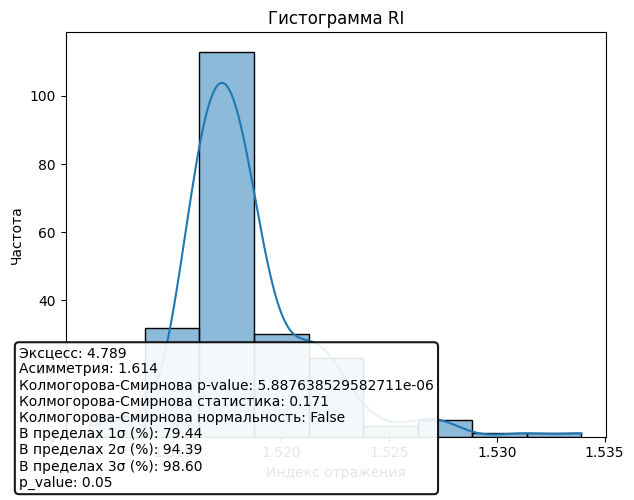

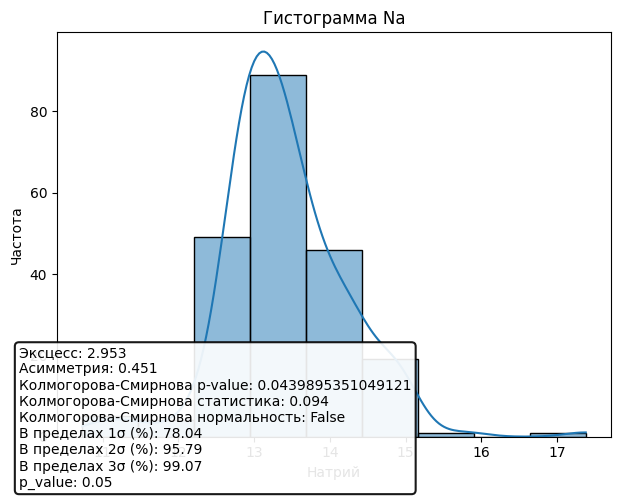

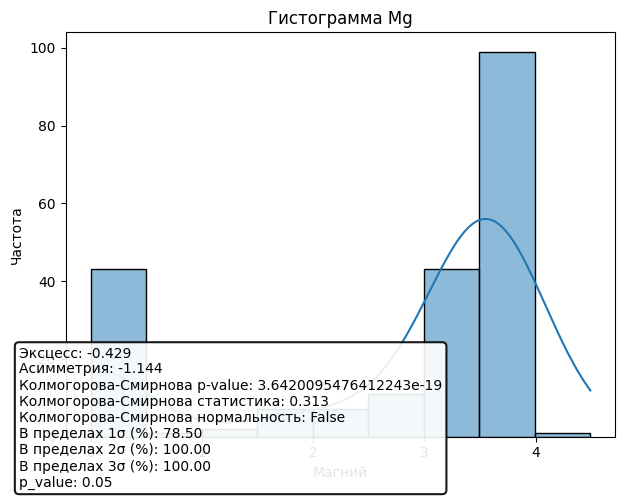

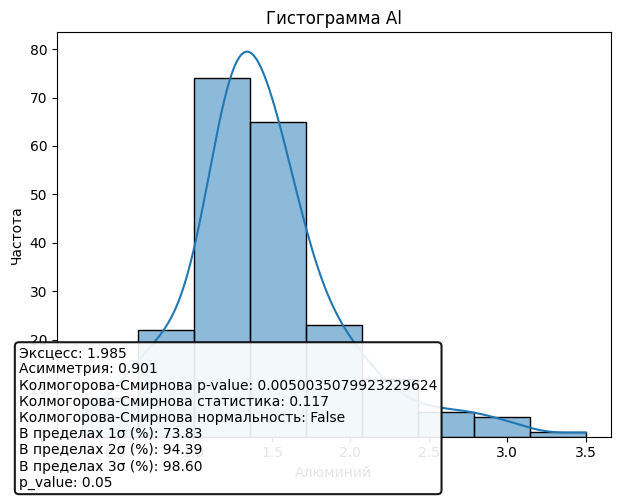

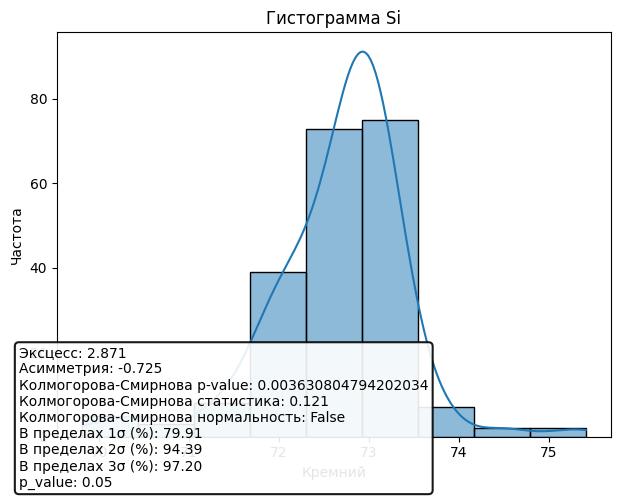

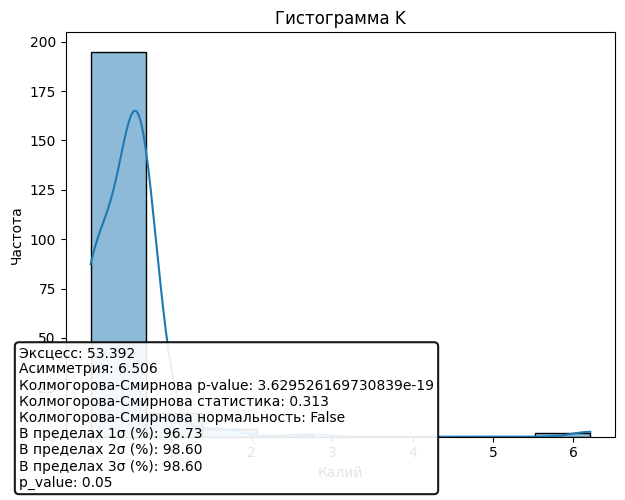

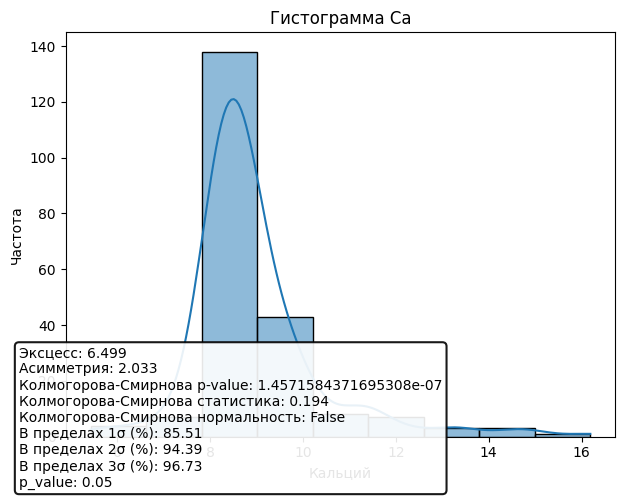

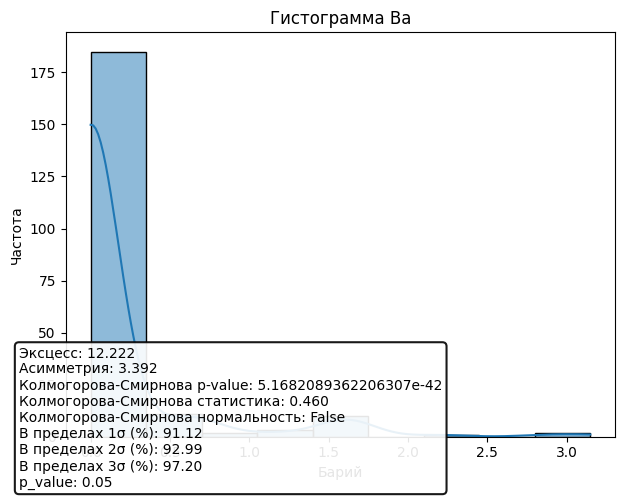

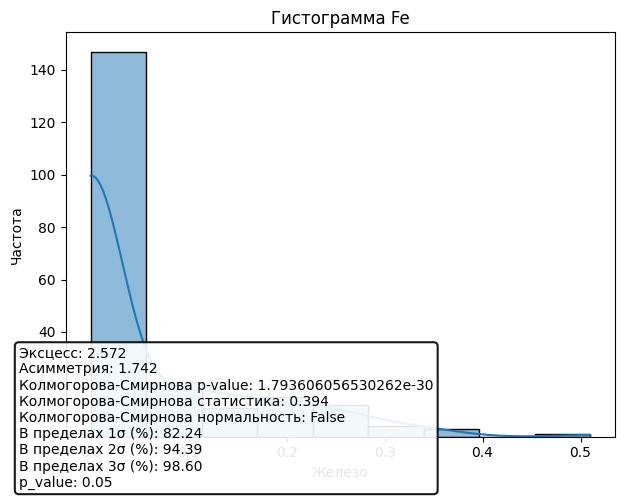

In [73]:
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import norm, skew, kurtosis, kstest
import numpy

ALPHA = 0.05

print(df.describe())

descriptions = {
    "RI": "Индекс отражения",
    "Na": "Натрий",
    "Mg": "Магний",
    "Al": "Алюминий",
    "Si": "Кремний",
    "K": "Калий",
    "Ca": "Кальций",
    "Ba": "Барий",
    "Fe": "Железо"
}

def three_sigma(column_data):
    mean_value = numpy.mean(column_data)
    std_value = numpy.std(column_data)

    bounds_1sigma = {
        'lower': mean_value - std_value,
        'upper': mean_value + std_value
    }

    bounds_2sigma = {
        'lower': mean_value - std_value * 2,
        'upper': mean_value + std_value * 2
    }

    bounds_3sigma = {
        'lower': mean_value - std_value * 3,
        'upper': mean_value + std_value * 3
    }

    total_count = len(column_data)

    within_1sigma = ((column_data >= bounds_1sigma['lower']) & 
                    (column_data <= bounds_1sigma['upper'])).sum()
    within_1sigma_pct = (within_1sigma / total_count) * 100

    within_2sigma = ((column_data >= bounds_2sigma['lower']) & 
                    (column_data <= bounds_2sigma['upper'])).sum()
    within_2sigma_pct = (within_2sigma / total_count) * 100

    within_3sigma = ((column_data >= bounds_3sigma['lower']) & 
                    (column_data <= bounds_3sigma['upper'])).sum()
    within_3sigma_pct = (within_3sigma / total_count) * 100
    
    return [within_1sigma_pct, within_2sigma_pct, within_3sigma_pct]


for _,column in enumerate(df.columns):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    three_sigma_pct = three_sigma(df[column])
    sb.histplot(df[column], kde=True, bins='sturges')
    kstestObject = kstest(df[column], 'norm', args=(numpy.mean(df[column]), numpy.std(df[column])))

    legendText = (f'Эксцесс: {kurtosis(df[column]):.3f}\n'
              f'Асимметрия: {skew(df[column]):.3f}\n'
              f'Колмогорова-Смирнова p-value: {kstestObject.pvalue}\n'
              f'Колмогорова-Смирнова статистика: {kstestObject.statistic:.3f}\n'
              f'Колмогорова-Смирнова нормальность: {kstestObject.pvalue >= ALPHA}\n'
              f'В пределах 1σ (%): {three_sigma_pct[0]:.2f}\n' # Теоретически 1σ (%) = 68.26
              f'В пределах 2σ (%): {three_sigma_pct[1]:.2f}\n' # Теоретически 2σ (%) = 95.44
              f'В пределах 3σ (%): {three_sigma_pct[2]:.2f}\n' # Теоретически 3σ (%) = 99.72
              f'p_value: {ALPHA}')
    plt.figtext(0.02, 0.01, legendText, 
            ha='left',
            va='bottom',
            fontsize=10,
            bbox=dict(boxstyle='round', 
                      facecolor='white', 
                      edgecolor='black',
                      linewidth=1.5,
                      alpha=0.9))
    plt.subplots_adjust(bottom=0.5)

    plt.title(f'Гистограмма {column}')
    plt.xlabel(descriptions[column])
    plt.ylabel('Частота') 
    plt.tight_layout()


---

### Оценка информационной значимости признаков

In [74]:
variances = df.var()
print('Дисперсия признаков:')
print(variances.sort_values())

Дисперсия признаков:
RI    0.000009
Fe    0.009494
Ba    0.247227
Al    0.249270
K     0.425354
Si    0.599921
Na    0.666841
Ca    2.025366
Mg    2.080540
dtype: float64


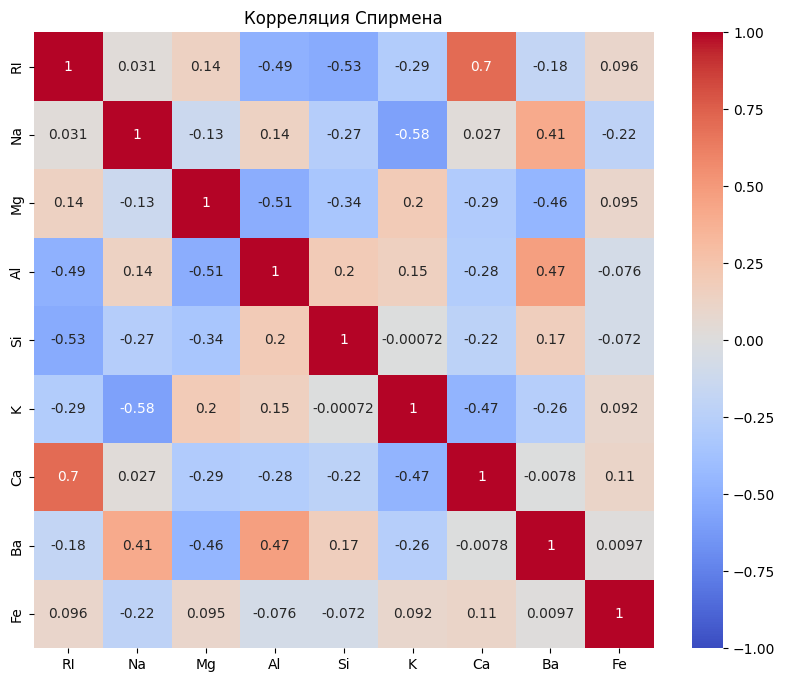

In [75]:
from scipy.stats import spearmanr

feature_columns = [col for col in df.columns if col != 'Class']
correlation_matrix = pd.DataFrame(index=feature_columns, columns=feature_columns)

for var1 in feature_columns:
    for var2 in feature_columns:
        if var1 != var2:
            corr, p_value = spearmanr(df[var1], df[var2])
            correlation_matrix.loc[var1, var2] = 'Значима' if p_value < ALPHA else 'Не значима'

spearman_corr = df[feature_columns].corr(method='spearman')

plt.figure(figsize=(10, 8))
sb.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляция Спирмена')
plt.show()


---

### Проверка условий для кластеризации

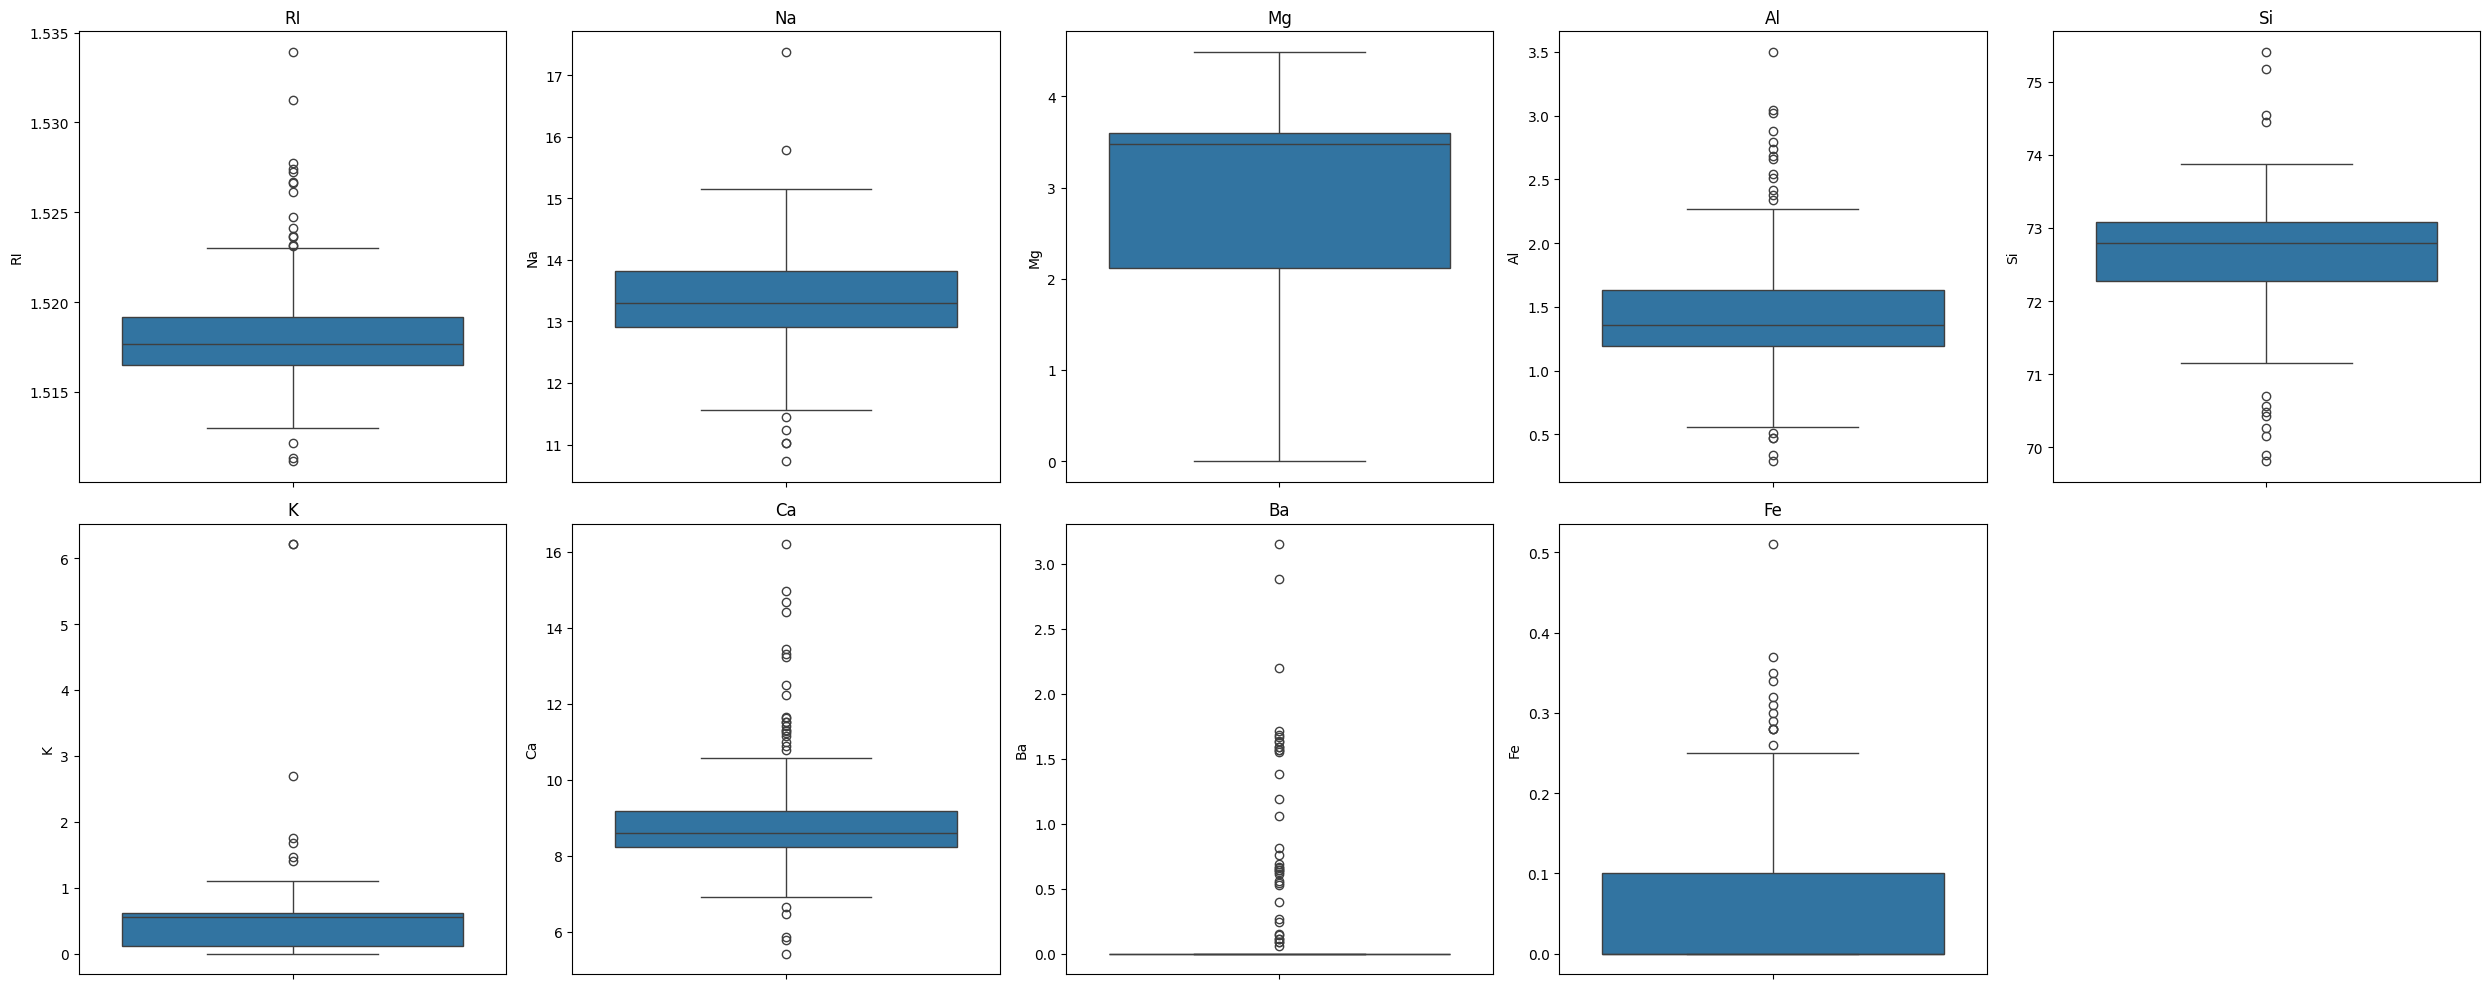

In [76]:
cols = df.columns
n_cols = 5
n_rows = (len(cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    sb.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Анализ результатов:

#### **Дескриптивный анализ**:

Все признаки не соответствуют нормальному распределению.

Большинство методов кластеризации не требуют нормальности, но это нужно учитывать при выборе метрики расстояния и масштабирования признаков.

#### **Информационная значимость признаков**:

| Признак | Дисперсия | Вывод |
| --- | --- | --- |
| RI, Fe | Очень малая дисперсия | Эти признаки почти одинаковы для большинства объектов, следовательно, **неинформативны для разделения кластеров**, их можно исключить или использовать осторожно. |
| Ba, Al, K, Si, Na | Средняя дисперсия | Признаки несут умеренную информацию о составе стекла, стоит оставить. |
| Ca, Mg | Очень большая дисперсия | Эти признаки сильно различают объекты, следовательно, это **важные признаки для кластеризации**, но без масштабирования они будут доминировать. |

**Корреляционный анализ:**

Сильная положительная корреляция:
- RI и Ca, Al и Ba, Ba и Al - эти признаки частично дублируют информацию;
    - Для кластеризации можно оставить один признак из пары высококоррелированных, чтобы уменьшить размерность.
- Сильная отрицательная корреляция:
    - RI с Al и Si, Mg с Al - эти признаки несут противоположную информацию о составе стекла, что полезно для разделения кластеров.
- Практически некоррелированные признаки:
    - Fe практически не коррелирует с другими признаками, добавляет уникальную информацию для различения объектов.

#### **Проверка условий для кластеризации**:

- Целевая переменная отсутствует, датасет готов для кластеризации.
- Ящики с усами показывают значительное количество выбросов на всех признаках (кроме Fe, где разброс минимален). Причины:
    - Разные масштабы измерений (RI ~1.5, Mg и Ca ~2, Na ~13, Si ~73 и т.д.);
    - Естественная вариативность химического состава стекла.
- Признаки отражают реальные характеристики стекла, кластеризация имеет смысл, особенно после масштабирования признаков.

С учётом всего выше сказанного, из датасета необходимо убрать переменные **RI** и **Fe**.

In [77]:
col_to_drop = ['RI', 'Fe']
df = df.drop(columns=col_to_drop)
print(df.head())

      Na    Mg    Al     Si     K    Ca   Ba
0  13.64  4.49  1.10  71.78  0.06  8.75  0.0
1  13.89  3.60  1.36  72.73  0.48  7.83  0.0
2  13.53  3.55  1.54  72.99  0.39  7.78  0.0
3  13.21  3.69  1.29  72.61  0.57  8.22  0.0
4  13.27  3.62  1.24  73.08  0.55  8.07  0.0


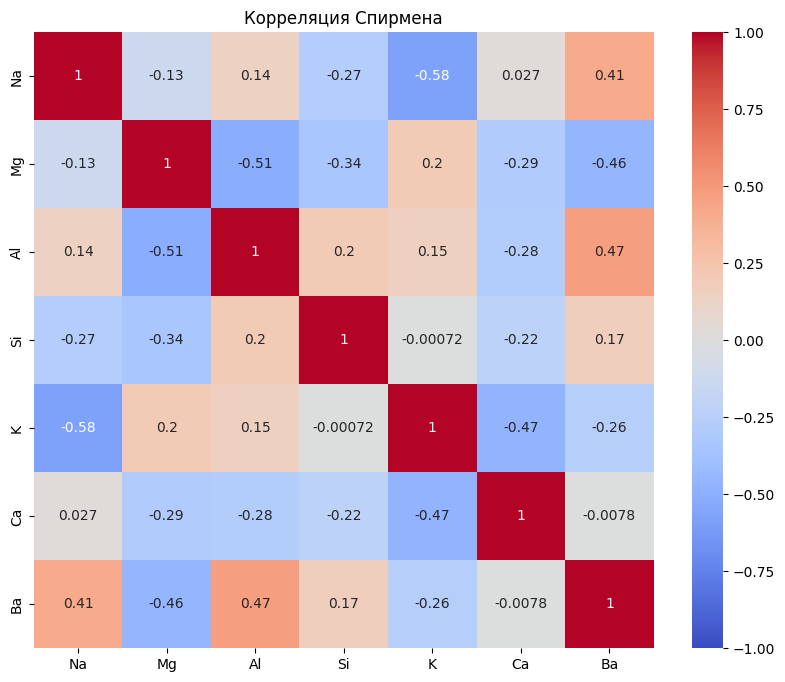

In [78]:
feature_columns = [col for col in df.columns if col != 'Class']
correlation_matrix = pd.DataFrame(index=feature_columns, columns=feature_columns)

for var1 in feature_columns:
    for var2 in feature_columns:
        if var1 != var2:
            corr, p_value = spearmanr(df[var1], df[var2])
            correlation_matrix.loc[var1, var2] = 'Значима' if p_value < ALPHA else 'Не значима'

spearman_corr = df[feature_columns].corr(method='spearman')

plt.figure(figsize=(10, 8))
sb.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляция Спирмена')
plt.show()


---

## Стандратизация / нормализация числовых признаков